# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
print('keras using %s backend'%keras.backend.backend())
import matplotlib.pyplot as graph
%matplotlib inline
graph.rcParams['figure.figsize'] = (15,5)
graph.rcParams["font.family"] = 'DejaVu Sans'
graph.rcParams["font.size"] = '12'
graph.rcParams['image.cmap'] = 'rainbow'

Using TensorFlow backend.


keras using tensorflow backend



Bad key "text.kerning_factor" on line 4 in
/Users/dathuynh/opt/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
import IPython.display as display
from PIL import Image
import os

In [4]:
tf.__version__

'2.2.0'

In [5]:
import pandas as pd
dataset = pd.read_csv('dataset/Chest_xray_Corona_Metadata.csv')
# Preview the dataset
print(dataset.head())

   Unnamed: 0   X_ray_image_name   Label Dataset_type Label_2_Virus_category  \
0           0  IM-0128-0001.jpeg  Normal        TRAIN                    NaN   
1           1  IM-0127-0001.jpeg  Normal        TRAIN                    NaN   
2           2  IM-0125-0001.jpeg  Normal        TRAIN                    NaN   
3           3  IM-0122-0001.jpeg  Normal        TRAIN                    NaN   
4           4  IM-0119-0001.jpeg  Normal        TRAIN                    NaN   

  Label_1_Virus_category  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  


In [6]:
# Remove the extra column and change the 'Label' to binary values
dataset = dataset.drop(['Unnamed: 0'], axis=1)
dataset['Label'].replace({"Normal": 0, "Pnemonia": 1}, inplace=True)
dataset = dataset.fillna(0)

In [7]:
dataset.set_index('X_ray_image_name', inplace=True)

In [8]:
print(dataset.head())
print("Shape of data set:", dataset.shape)

                   Label Dataset_type Label_2_Virus_category  \
X_ray_image_name                                               
IM-0128-0001.jpeg      0        TRAIN                      0   
IM-0127-0001.jpeg      0        TRAIN                      0   
IM-0125-0001.jpeg      0        TRAIN                      0   
IM-0122-0001.jpeg      0        TRAIN                      0   
IM-0119-0001.jpeg      0        TRAIN                      0   

                  Label_1_Virus_category  
X_ray_image_name                          
IM-0128-0001.jpeg                      0  
IM-0127-0001.jpeg                      0  
IM-0125-0001.jpeg                      0  
IM-0122-0001.jpeg                      0  
IM-0119-0001.jpeg                      0  
Shape of data set: (5910, 4)


In [9]:
import pathlib
data_dir = pathlib.Path('dataset/Coronahack-Chest-XRay-Dataset')

In [10]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

5887


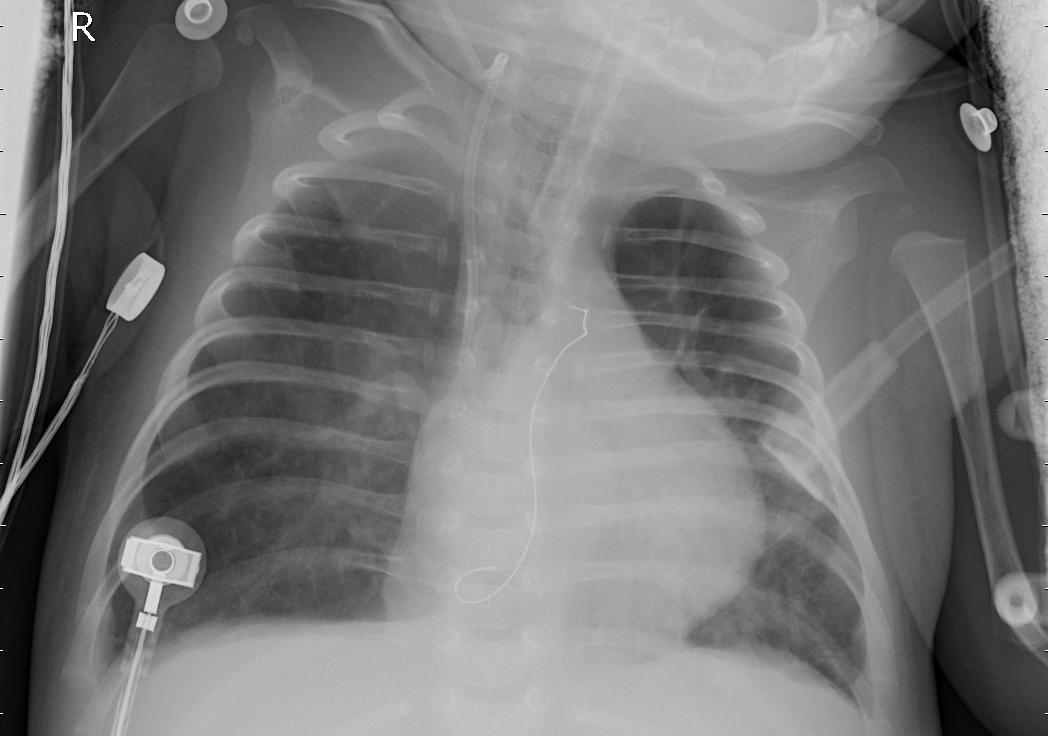

5263


In [11]:
train_img = list(data_dir.glob('train/*.jpeg'))
for image_path in train_img[:1]:
    display.display(Image.open(str(image_path)))
print(len(train_img))

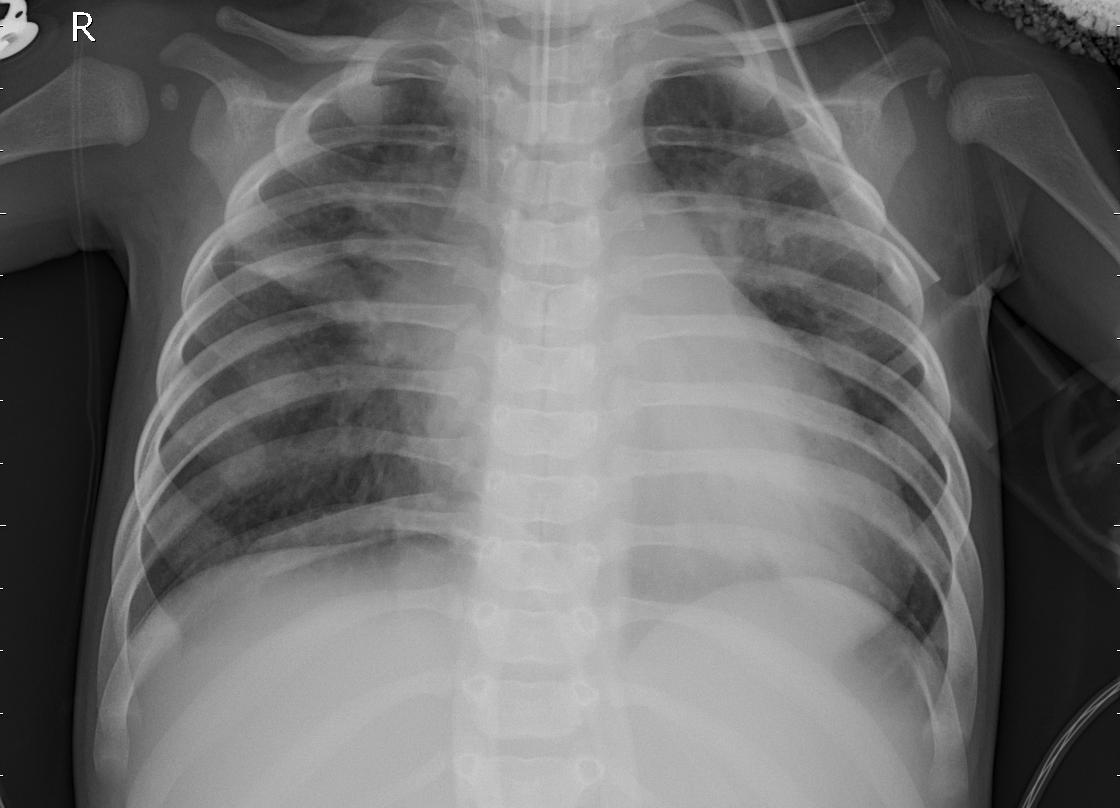

624


In [12]:
test_img = list(data_dir.glob('test/*.jpeg'))
for image_path in test_img[:1]:
    display.display(Image.open(str(image_path)))
print(len(test_img))

In [13]:
# Check a dataset length
def ds_length(dataset):
    num_elements = 0
    for element in dataset:
        num_elements += 1
    return num_elements

In [14]:
# To load the files as a tf.data.Dataset first create a train dataset of the file paths
train_dir1 = tf.data.Dataset.list_files(str(data_dir/'train/NORMAL*.jpeg'))
train_dir2 = tf.data.Dataset.list_files(str(data_dir/'train/person*.jpeg'))
train_dir3 = tf.data.Dataset.list_files(str(data_dir/'train/IM*.jpeg'))
train_dir = (train_dir1.concatenate(train_dir2)).concatenate(train_dir3)
print('Number of train samples: ', ds_length(train_dir))

Number of train samples:  5216


In [15]:
for f in train_dir.take(5):
    print(f.numpy())

b'dataset/Coronahack-Chest-XRay-Dataset/train/NORMAL2-IM-0834-0001.jpeg'
b'dataset/Coronahack-Chest-XRay-Dataset/train/NORMAL2-IM-1343-0001.jpeg'
b'dataset/Coronahack-Chest-XRay-Dataset/train/NORMAL2-IM-1245-0001.jpeg'
b'dataset/Coronahack-Chest-XRay-Dataset/train/NORMAL2-IM-1234-0001.jpeg'
b'dataset/Coronahack-Chest-XRay-Dataset/train/NORMAL2-IM-0818-0001-0002.jpeg'


In [16]:
# To load the files as a tf.data.Dataset first create a test dataset of the file paths
test_dir = tf.data.Dataset.list_files(str(data_dir/'test/*.jpeg'))
print('Number of test samples: ', ds_length(test_dir))

Number of test samples:  624


In [17]:
for f in test_dir.take(5):
    print(f.numpy())

b'dataset/Coronahack-Chest-XRay-Dataset/test/NORMAL2-IM-0381-0001.jpeg'
b'dataset/Coronahack-Chest-XRay-Dataset/test/person80_bacteria_390.jpeg'
b'dataset/Coronahack-Chest-XRay-Dataset/test/IM-0043-0001.jpeg'
b'dataset/Coronahack-Chest-XRay-Dataset/test/NORMAL2-IM-0374-0001-0002.jpeg'
b'dataset/Coronahack-Chest-XRay-Dataset/test/NORMAL2-IM-0353-0001.jpeg'


In [18]:
# Image quality and dataset setting
BATCH_TRAIN_SIZE = 100
BATCH_TEST_SIZE = 25
IMG_HEIGHT = 50
IMG_WIDTH = 70

# Tensorflow function that converts a file path to an (img, label) pair

In [19]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = str(file_path).split(os.path.sep)
    # The last is the image's name
    img_name = parts[-1].rstrip("'")
    # Get the label (0: 'Normal'/1: 'Pnemonia') from the dataset
    try:
        label = dataset.loc[img_name, 'Label']
    except KeyError:
        label = 0
    return label

In [20]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use 'convert_image_dtype' to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [21]:
def process_path(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    label = tf.numpy_function(func=get_label, inp=[file_path], Tout=tf.int64)
    return img, label

In [22]:
# Use Dataset.map to create a dataset of image, label pairs:
# Set 'num_parallel_calls' so multiple images are loaded/processed in parallel.
train_ds = train_dir.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_dir.map(process_path, num_parallel_calls=AUTOTUNE)

In [23]:
for image, label in train_ds.take(1):
    print('Image shape for training: ', image.numpy().shape)
    print('Label for training: ', label.numpy())
for image, label in test_ds.take(1):
    print('Image shape for testing: ', image.numpy().shape)
    print('Label for testing: ', label.numpy())

Image shape for training:  (50, 70, 3)
Label for training:  0
Image shape for testing:  (50, 70, 3)
Label for testing:  1


In [24]:
def prepare_for_training(ds, batch_size=BATCH_TRAIN_SIZE, cache=True, shuffle_buffer_size=50):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # Repeat forever
    ds = ds.repeat()
    ds = ds.batch(batch_size)

    # `prefetch` lets the dataset fetch batches in the background while the model is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [25]:
train_ds = prepare_for_training(train_ds, BATCH_TRAIN_SIZE)
test_ds = prepare_for_training(test_ds, BATCH_TEST_SIZE)

In [26]:
train_X, train_Y = next(iter(train_ds))
test_X, test_Y = next(iter(test_ds))

In [27]:
def show_batch(image_batch, label_batch):
    graph.figure(figsize=(10,10))
    for n in range(25):
        ax = graph.subplot(5,5,n+1)
        #graph.imshow(image_batch[n])
        graph.imshow(image_batch[n], cmap = 'gray', interpolation = 'nearest')
        graph.title(label_batch[n].numpy())
        graph.axis('off')

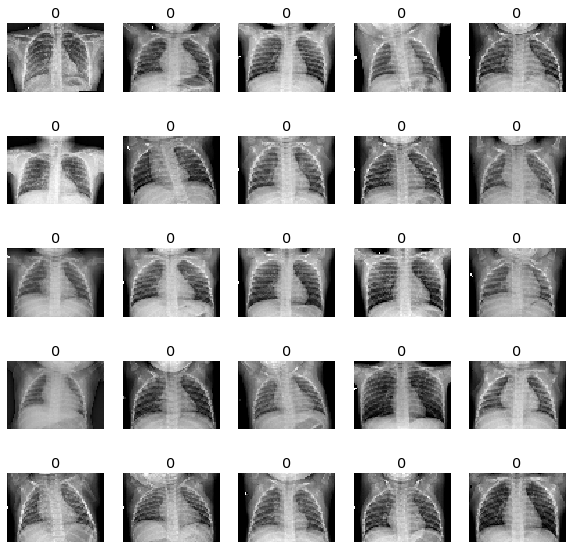

In [28]:
show_batch(train_X.numpy(), train_Y)

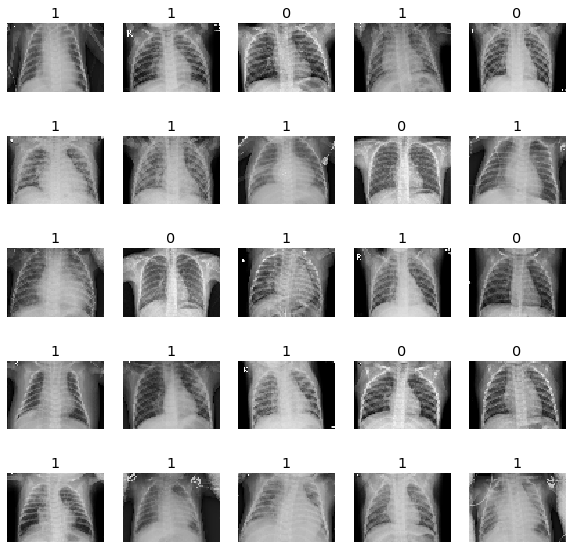

In [29]:
show_batch(test_X.numpy(), test_Y)

In [30]:
print('train_X:', train_X.shape, end = '')
print(', train_Y:', train_Y.shape)
print('test_X:', test_X.shape, end = '')
print(', test_Y:', test_Y.shape)

train_X: (100, 50, 70, 3), train_Y: (100,)
test_X: (25, 50, 70, 3), test_Y: (25,)


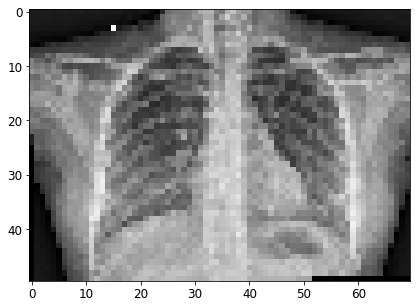

In [31]:
graph.imshow(train_X[0], cmap = 'gray', interpolation = 'nearest')
graph.show()

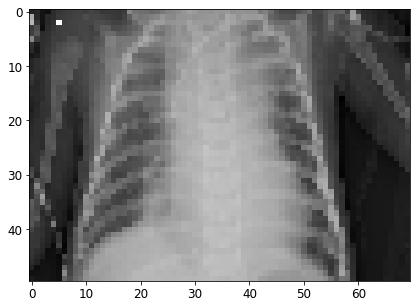

In [32]:
graph.imshow(test_X[0], cmap = 'gray', interpolation = 'nearest')
graph.show()

In [33]:
# Convert images to grayscale (1 dimension)
train_X = tf.image.rgb_to_grayscale(train_X)
test_X = tf.image.rgb_to_grayscale(test_X)

# Convert the image dataset from Tensor to Numpy array
train_X = np.array(train_X)
test_X = np.array(test_X)

# train_X = train_X.reshape(train_X.shape[0], IMG_HEIGHT, IMG_WIDTH, 1)
# test_X = test_X.reshape(test_X.shape[0], IMG_HEIGHT, IMG_WIDTH, 1)

In [34]:
split_index = BATCH_TRAIN_SIZE * 80 // 100

# Split 20% of train dataset for validation
valid_X = train_X[split_index:]
valid_Y = train_Y[split_index:]

train_X = train_X[:split_index]
train_Y = train_Y[:split_index]

In [35]:
# We scale the values so they are between 0 and 1, instead of 0 and 255.
train_X = train_X / 255
valid_X = valid_X / 255
test_X = test_X / 255

# Now we print the label for the first example
print('Number of samples for training:', ds_length(train_X))
print('Number of samples for validation:', ds_length(valid_X))
print('Number of samples for testing:', ds_length(test_X))

Number of samples for training: 80
Number of samples for validation: 20
Number of samples for testing: 25


The label is a number - the number we see when we view the image. We need represent this number as a one-hot vector, so the neural network knows it is a category.

In [36]:
train_Y = keras.utils.to_categorical(train_Y, 2)
valid_Y = keras.utils.to_categorical(valid_Y, 2)
test_Y = keras.utils.to_categorical(test_Y, 2)
print('First label in training set:', train_Y[0])
print('First label in validation set:', valid_Y[0])
print('First label in testing set:', test_Y[0])

First label in training set: [1. 0.]
First label in validation set: [1. 0.]
First label in testing set: [0. 1.]


# Build a neural network.

In [37]:
# Sets a randomisation seed for replicatability.
np.random.seed(6)
model = Sequential()

In [38]:
# Setup pre-processing layer of the network 
# activation 'elu', 'selu', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'softplus', 'softsign', 'linear']
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'softsign', input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)))
model.add(Conv2D(128, (3, 3), activation = 'softsign'))

In [39]:
# Pooling layers help speed up training time and make features it detects more robust.
# They act by downsampling the data - reducing the data size and complexity.
model.add(MaxPooling2D(pool_size = (2, 2)))

# Dropout is a technique to help prevent overfitting
# It makes nodes 'dropout' - turning them off randomly.
model.add(Dropout(0.125))

model.add(Flatten())

In [40]:
# Dense layers perform classification - we have extracted the features with the convolutional pre-processing
model.add(Dense(128, activation='softsign'))

# More dropout!
model.add(Dropout(0.25))

# Next is our output layer
# Softmax outputs the probability for each category
model.add(Dense(2, activation=tf.nn.softmax))
###

# And finally, we compile.
# optimization 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Train

In [41]:
# training_stats = model.fit(train_X, train_Y, batch_size = 128, epochs = 5, verbose = 1, validation_data = (valid_X, valid_Y))
training_stats = model.fit(train_X, train_Y, batch_size = 128, epochs = 10, verbose = 1, validation_data = (valid_X, valid_Y))

# 2000 - 50 x 70
# softsign 0.94 75.50 epochs = 10-12
# linear   0.87 76.50 epochs = 8

# 2000 - 100 x 140
# softsign 0.93 87.00 (83.00) epochs = 10
# linear   0.75 61.50 epochs = 10

# 3000 - 100 x 140
# softsign 0.93 77.20 epochs = 10

# 5000 - 50 x 70
# softsign 0.95 78.80 epochs = 9-10
# linear   0.95 74.80 epochs = 8

# 5000 - 100 x 140
# softsign 0.96 76.60 epochs = 12, 0.94 76.80 epochs = 6, 
# linear   epochs = 10

Train on 80 samples, validate on 20 samples
Epoch 1/10
80/80 [==============================] - 2s 28ms/step - loss: 0.6933 - accuracy: 0.2500 - val_loss: 0.3982 - val_accuracy: 1.0000
Epoch 2/10
80/80 [==============================] - 2s 24ms/step - loss: 0.3960 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 3/10
80/80 [==============================] - 2s 25ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 3.8196e-04 - val_accuracy: 1.0000
Epoch 4/10
80/80 [==============================] - 2s 21ms/step - loss: 4.4207e-04 - accuracy: 1.0000 - val_loss: 4.4250e-05 - val_accuracy: 1.0000
Epoch 5/10
80/80 [==============================] - 2s 22ms/step - loss: 6.0230e-05 - accuracy: 1.0000 - val_loss: 9.4771e-06 - val_accuracy: 1.0000
Epoch 6/10
80/80 [==============================] - 2s 22ms/step - loss: 1.0459e-05 - accuracy: 1.0000 - val_loss: 3.0279e-06 - val_accuracy: 1.0000
Epoch 7/10
80/80 [==============================] - 2s 24ms/step - loss: 4.2438e-0

Test Set Evaluation: loss = 10.971226, accuracy = 28.00


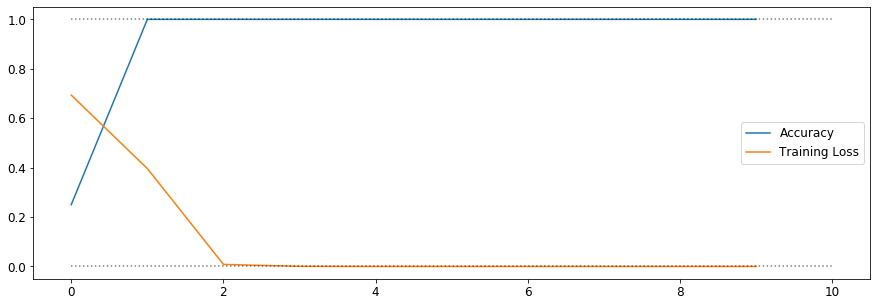

In [42]:
evaluation = model.evaluate(test_X, test_Y, verbose=0)

print('Test Set Evaluation: loss = %0.6f, accuracy = %0.2f' %(evaluation[0], 100 * evaluation[1]))

# We can plot our training statistics to see how it developed over time
accuracy, = graph.plot(training_stats.history['accuracy'], label = 'Accuracy')
training_loss, = graph.plot(training_stats.history['loss'], label = 'Training Loss')
graph.legend(handles = [accuracy, training_loss])
loss = np.array(training_stats.history['loss'])
xp = np.linspace(0,loss.shape[0],10 * loss.shape[0])
graph.plot(xp, np.full(xp.shape, 1), c = 'k', linestyle = ':', alpha = 0.5)
graph.plot(xp, np.full(xp.shape, 0), c = 'k', linestyle = ':', alpha = 0.5)
graph.show()